In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (precision_score, recall_score, jaccard_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, classification_report, jaccard_score, f1_score)
import torch
from transformers import (SegformerImageProcessor, SegformerConfig)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3  # Ajusta si tienes diferente número de clases
IMAGE_SIZE = 256

/home/jose/.local/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, mask_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

def get_image_mask_paths(folder):
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]
    return image_files, mask_files

In [3]:
dataset_path = "content/my-datasets"
test_path = os.path.join(dataset_path, "test")

test_images, test_masks = get_image_mask_paths(test_path)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_dataset = CustomSegmentationDataset(
    image_dir=test_path,
    mask_dir=test_path,
    image_files=test_images,
    mask_files=test_masks,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
model_paths = {
    "UNET": "../models/UNET.pth",
    "DEEPLABV3+": "../models/DEEPLAB.pth",
    "SEGFORMER": "../models/SEGFORMER.pth"
}

# Procesador para SEGFORMER
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

id2label = {
    2: "suelo expuesto",
    3: "vegetacion seca",
    4: "vegetacion verde"
}
label2id = {v: k for k, v in id2label.items()}

# Configuración personalizada
config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id
)

def load_model(model_name, model_path):
    # Cargar directamente el modelo completo desde el archivo .pth
    model = torch.load(model_path, map_location=DEVICE, weights_only=False)
    
    model = model.to(DEVICE)
    model.eval()
    return model

/home/jose/.local/lib/python3.13/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [5]:
def get_num_classes(model):
    # Modelos Hugging Face (como SegFormer)
    if hasattr(model, "config") and hasattr(model.config, "num_labels"):
        return model.config.num_labels
    
    # Modelos de segmentation_models_pytorch
    elif hasattr(model, "segmentation_head"):
        head = model.segmentation_head
        # Acceder al último Conv2d si está encapsulado
        if hasattr(head, 'out_channels'):
            return head.out_channels
        elif isinstance(head, torch.nn.Sequential):
            for layer in reversed(head):
                if isinstance(layer, torch.nn.Conv2d):
                    return layer.out_channels
        elif isinstance(head, torch.nn.Conv2d):
            return head.out_channels
    
    # Arquitecturas personalizadas tipo U-Net
    elif hasattr(model, "model") and isinstance(model.model[-1], torch.nn.Conv2d):
        return model.model[-1].out_channels
    
    raise ValueError("No se pudo determinar el número de clases del modelo.")

In [6]:
# Carga e imprime clases por modelo
for model_name, model_path in model_paths.items():
    model = load_model(model_name, model_path)
    num_classes = get_num_classes(model)
    print(f"{model_name} tiene {num_classes} clases")

UNET tiene 5 clases
DEEPLABV3+ tiene 5 clases
SEGFORMER tiene 5 clases


In [7]:
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Revierte la normalización de ImageNet aplicada a una imagen tensorial."""
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

In [8]:
def plot_confusion_matrix(y_true, y_pred, labels, target_names, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names,
        linewidths=0.5,
        linecolor='black',
        annot_kws={"size": 10}
    )
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Evaluando modelo: UNET
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.8221    0.8434    0.8326    299972
 vegetacion seca     0.8587    0.8269    0.8425    378135
vegetacion verde     0.8481    0.8702    0.8590    239397

        accuracy                         0.8436    917504
       macro avg     0.8430    0.8468    0.8447    917504
    weighted avg     0.8440    0.8436    0.8436    917504



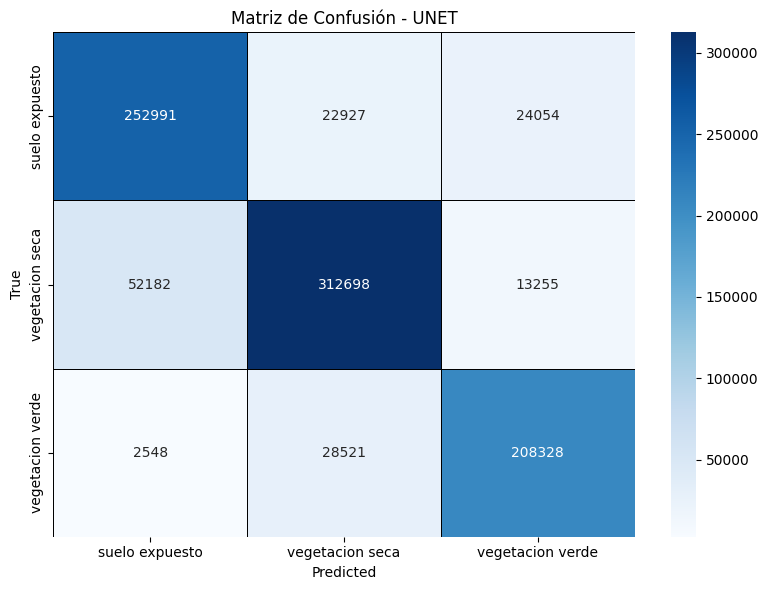


IoU Promedio (macro):
0.7313
IoU por clase:
  suelo expuesto: 0.7132
  vegetacion seca: 0.7279
  vegetacion verde: 0.7529

Precisión de píxeles: 0.8436

F1-score (macro / Dice promedio): 0.8447
F1-score (ponderado): 0.8436
F1-score por clase:
  suelo expuesto: 0.8326
  vegetacion seca: 0.8425
  vegetacion verde: 0.8590

Precisión por clase:
  suelo expuesto: 0.8221
  vegetacion seca: 0.8587
  vegetacion verde: 0.8481

Recall por clase:
  suelo expuesto: 0.8434
  vegetacion seca: 0.8269
  vegetacion verde: 0.8702

Balanced Accuracy: 0.8468
Matthews Correlation Coefficient (MCC): 0.7621

------------------------------------------------------------

Evaluando modelo: DEEPLABV3+
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.6956    0.7541    0.7236    299404
 vegetacion seca     0.7234    0.7357    0.7295    378499
vegetacion verde     0.9140    0.7934    0.8494    239601

        accuracy                         0.7568    9175

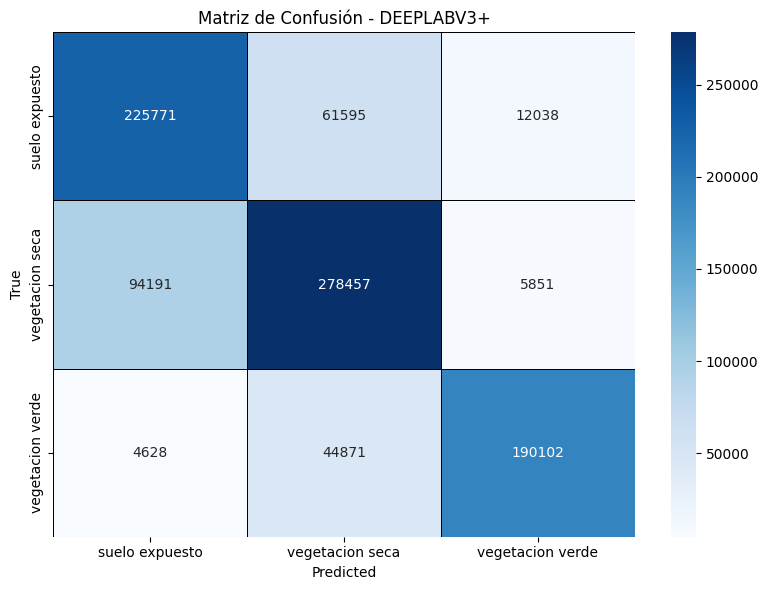


IoU Promedio (macro):
0.6265
IoU por clase:
  suelo expuesto: 0.5669
  vegetacion seca: 0.5742
  vegetacion verde: 0.7383

Precisión de píxeles: 0.7568

F1-score (macro / Dice promedio): 0.7675
F1-score (ponderado): 0.7589
F1-score por clase:
  suelo expuesto: 0.7236
  vegetacion seca: 0.7295
  vegetacion verde: 0.8494

Precisión por clase:
  suelo expuesto: 0.6956
  vegetacion seca: 0.7234
  vegetacion verde: 0.9140

Recall por clase:
  suelo expuesto: 0.7541
  vegetacion seca: 0.7357
  vegetacion verde: 0.7934

Balanced Accuracy: 0.7611
Matthews Correlation Coefficient (MCC): 0.6281

------------------------------------------------------------

Evaluando modelo: SEGFORMER
Reporte de Clasificación:
                  precision    recall  f1-score   support

  suelo expuesto     0.8362    0.9218    0.8769    299650
 vegetacion seca     0.9111    0.7340    0.8131    378418
vegetacion verde     0.7727    0.9111    0.8362    239436

        accuracy                         0.8416    91750

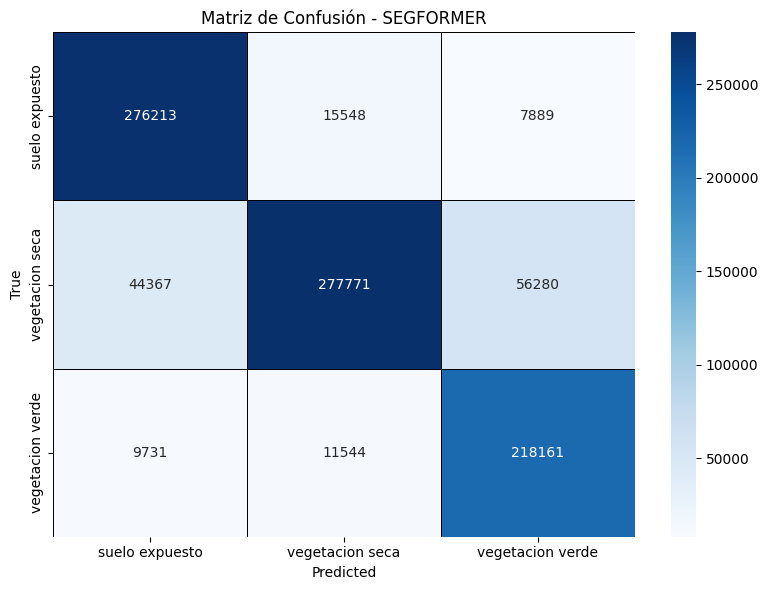


IoU Promedio (macro):
0.7281
IoU por clase:
  suelo expuesto: 0.7808
  vegetacion seca: 0.6850
  vegetacion verde: 0.7186

Precisión de píxeles: 0.8416

F1-score (macro / Dice promedio): 0.8421
F1-score (ponderado): 0.8400
F1-score por clase:
  suelo expuesto: 0.8769
  vegetacion seca: 0.8131
  vegetacion verde: 0.8362

Precisión por clase:
  suelo expuesto: 0.8362
  vegetacion seca: 0.9111
  vegetacion verde: 0.7727

Recall por clase:
  suelo expuesto: 0.9218
  vegetacion seca: 0.7340
  vegetacion verde: 0.9111

Balanced Accuracy: 0.8557
Matthews Correlation Coefficient (MCC): 0.7674

------------------------------------------------------------



In [ ]:
# Mapeo completo de clases posibles
id2label_full = {
    0: "fondo",
    1: "agua",
    2: "suelo expuesto",
    3: "vegetacion seca",
    4: "vegetacion verde"
}

# Detectar dinámicamente todas las clases presentes en las máscaras
all_labels = set()
for _, masks in test_loader:
    for mask in masks:
        unique = torch.unique(mask)
        all_labels.update(unique.cpu().numpy())

labels = sorted(list(all_labels))
target_names = [id2label_full[i] for i in labels]

for model_name, model_path in model_paths.items():
    print(f"Evaluando modelo: {model_name}")
    model = load_model(model_name, model_path)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            if model_name == "SEGFORMER":
                for i in range(imgs.shape[0]):
                    img = denormalize(imgs[i])
                    img = img.permute(1, 2, 0).cpu().numpy()
                    img = np.clip(img, 0, 1)

                    inputs = feature_extractor(images=img, return_tensors="pt", do_rescale=False).to(DEVICE)
                    outputs = model(**inputs)
                    logits = outputs.logits

                    logits = torch.nn.functional.interpolate(
                        logits,
                        size=masks[i].shape[-2:],
                        mode="bilinear",
                        align_corners=False
                    )

                    pred = torch.argmax(logits, dim=1).squeeze(0)

                    y_true.append(masks[i].view(-1).cpu().numpy())
                    y_pred.append(pred.view(-1).cpu().numpy())
            else:
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1)

                y_true.append(masks.view(-1).cpu().numpy())
                y_pred.append(preds.view(-1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    print("Reporte de Clasificación:")
    print(classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        zero_division=0,
        digits=4
    ))

    plot_confusion_matrix(y_true, y_pred, labels=labels, target_names=target_names, model_name=model_name)

    # IoU
    iou_macro = jaccard_score(y_true, y_pred, average='macro', labels=labels)
    iou_per_class = jaccard_score(y_true, y_pred, average=None, labels=labels)

    print("\nIoU Promedio (macro):")
    print(f"{iou_macro:.4f}")
    print("IoU por clase:")
    for i, score in enumerate(iou_per_class):
        print(f"  {target_names[i]}: {score:.4f}")

    # Precisión de píxeles
    acc = (y_true == y_pred).sum() / len(y_true)
    print(f"\nPrecisión de píxeles: {acc:.4f}")

    # F1 (Dice)
    dice_macro = f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)
    dice_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)
    dice_per_class = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

    print(f"\nF1-score (macro / Dice promedio): {dice_macro:.4f}")
    print(f"F1-score (ponderado): {dice_weighted:.4f}")
    print("F1-score por clase:")
    for i, score in enumerate(dice_per_class):
        print(f"  {target_names[i]}: {score:.4f}")

    # Precision y Recall por clase
    precision_per_class = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

    print("\nPrecisión por clase:")
    for i, score in enumerate(precision_per_class):
        print(f"  {target_names[i]}: {score:.4f}")

    print("\nRecall por clase:")
    for i, score in enumerate(recall_per_class):
        print(f"  {target_names[i]}: {score:.4f}")

    # Balanced Accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\nBalanced Accuracy: {bal_acc:.4f}")

    # MCC
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    print(f"\n{'---'*20}\n")